In [77]:
pip install nltk


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [78]:
# importing libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [79]:
# Setting device to GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
     device = torch.device("cpu")

print(device)

cuda


In [80]:
# loading dataset
Dataset = 'IMDB_Dataset.csv'
dataset = pd.read_csv(Dataset)
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [81]:
# assigining x and y values and splitting the dataset into train and test datasets
X= dataset['review'].values
y = dataset['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y, test_size = 0.33)

In [82]:
# encoding sentiment values
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [83]:
# downloading stopwords using nltk library
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [84]:
# removing unwanted text using regualr expressions
def preprocessing_data(review):
    review=re.sub("\W+",' ',review)
    review=re.sub(r'\sn\s',' ',review)
    review=re.sub(r'\sr',' ',review)
    review=re.sub(r'[0-9]',' ',review)
    review=re.sub(r'\sxac',' ',review)
    review=re.sub(r'\sxe',' ',review)
    review=re.sub(r'\sx\s',' ',review)
    review=re.sub(r'\sdx\s',' ',review)
    review=re.sub(r'\sck\s',' ',review)
    review=re.sub(r'\sxc\s',' ',review)
    review=re.sub(r'\sxbd\s',' ',review)
    review=re.sub(r'\sxa\s',' ',review)
    review=re.sub(r'\sxa\s',' ',review)
    review=re.sub(r'\sxt\s',' ',review)
    review=re.sub(r'\sxf\s',' ',review)
    review=re.sub(r'\sxp\s',' ',review)
    review=re.sub(r'\sxzy\s',' ',review)
    review=re.sub(r'\sxs\s',' ',review)
    review=re.sub(r'\sxa\s',' ',review)
    review=re.sub(r'\sxsr\s',' ',review)
    review=re.sub(r'\sda\s',' ',review)
    review=re.sub(r'\sc\s',' ',review)
    review=re.sub(r'b\s+',' ',review)
    review=re.sub(r'\s+',' ',review)
    review=re.sub(r'\s[a-z]\s',' ',review)

    return review




In [85]:
# tokenization of the text
def tokenize(x_train,x_test):
    word_list = []
    train_list = []
    test_list = []

    stop_words = set(stopwords.words('english'))
    for i in x_train:
        for word in i.lower().split():
            word = preprocessing_data(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    text = Counter(word_list)
    total_words=len(text)
    sorted_words=text.most_common(1500)
    vocab = {w:i+1 for i,(w,u) in enumerate(sorted_words)}


    for i in x_train:
            train_list.append([vocab[preprocessing_data(word)] for word in i.lower().split()
                                     if preprocessing_data(word) in vocab.keys()])
    for j in x_test:
            test_list.append([vocab[preprocessing_data(word)] for word in j.lower().split()
                                    if preprocessing_data(word) in vocab.keys()])

    return np.array(train_list), np.array(test_list),vocab

In [86]:
x_train,x_test,vocabulary = tokenize(x_train,x_test)

<ipython-input-85-632b0c830e72>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(train_list), np.array(test_list),vocab


In [87]:
# padding to a sequence of length 300
def padding_col(reviews, len_seq):
    features = np.zeros((len(reviews), len_seq),dtype=int)
    for i, review in enumerate(reviews):
        if len(review) != 0:
            features[i, -len(review):] = np.array(review)[:len_seq]
    return features

In [88]:
# padding x values of training and testing data
x_train_ = padding_col(x_train,300)
x_test_= padding_col(x_test,300)
y_train = np.array(y_train)
y_test = np.array(y_test)

y_train_ = np.array(y_train_encoded, dtype=np.float64)
y_test_ = np.array(y_test_encoded, dtype=np.float64)

In [89]:
#Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_), torch.from_numpy(y_train_))
test_data = TensorDataset(torch.from_numpy(x_test_), torch.from_numpy(y_test_))

# dataloaders
batch_size = 50
# Initializing train loader and test loader
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [90]:
#defining GRU Architecture
class SentimentGRUNet(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentGRUNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        gru_out, hidden = self.gru(embeds, hidden)
        gru_out = gru_out[:, -1, :]
        out = self.dropout(gru_out)
        out = self.fc(out)
        sig_out = self.sigmoid(out)
        return sig_out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden


In [91]:
# Inputs to the GRU model
vocab_size = len(vocabulary) + 1
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

model = SentimentGRUNet(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5)
model.to(device)
print(model)


SentimentGRUNet(
  (embedding): Embedding(1501, 400)
  (gru): GRU(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [92]:
# initializing loss
criterion = nn.BCELoss()
# initilizing optimization functions
lr=0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [93]:
# Training LSTM  with 10 epochs
clip = 5
num_epochs = 10
train_loss = []
train_accuracy = []
for epoch in range(num_epochs):
    training_losses = []
    training_accuracy = 0
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        model.zero_grad()
        h = model.init_hidden(batch_size)
        h = h.data  # Detach hidden state from history
        output, h = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        training_losses.append(loss.item())
        output = torch.round(output.squeeze())
        accuracy = torch.sum(output == labels.squeeze()).item()
        training_accuracy += accuracy
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    train_loss_ = np.mean(training_losses)
    train_acc_ = training_accuracy/len(train_loader.dataset)
    train_loss.append(train_loss_)
    train_accuracy.append(train_acc_)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {train_loss_} train_accuracy : {train_acc_}')




Epoch 1
train_loss : 0.44524566159764334 train_accuracy : 0.7871641791044776
Epoch 2
train_loss : 0.31057118836845926 train_accuracy : 0.8699104477611941
Epoch 3
train_loss : 0.24838262048007836 train_accuracy : 0.9007761194029851
Epoch 4
train_loss : 0.17368263426000502 train_accuracy : 0.934
Epoch 5
train_loss : 0.11104545710997572 train_accuracy : 0.959910447761194
Epoch 6
train_loss : 0.07181624880533165 train_accuracy : 0.9736716417910448
Epoch 7
train_loss : 0.05398174675612419 train_accuracy : 0.9805373134328358
Epoch 8
train_loss : 0.043507301989497975 train_accuracy : 0.9849253731343284
Epoch 9
train_loss : 0.03733402627855609 train_accuracy : 0.9866865671641791
Epoch 10
train_loss : 0.03520617127981482 train_accuracy : 0.9871044776119403


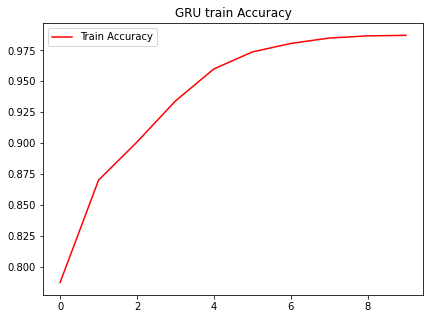

In [94]:
# plotting curve for training accuracy of GRU
fig = plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy', color = 'red')
plt.title("GRU train Accuracy")
plt.legend()

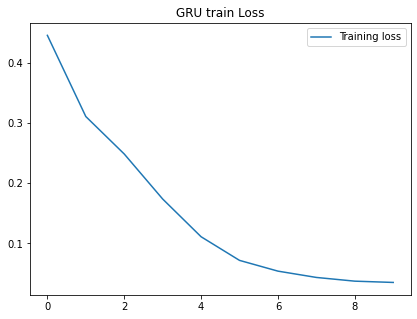

In [95]:
# plotting curve for loss for GRU training
fig = plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training loss')
plt.title("GRU train Loss")
plt.legend()

In [96]:
# testing LSTM model with 10 epochs
clip = 5
num_epochs = 10
test_loss_list = []
test_accuracy = []
for epoch in range(num_epochs):
    test_h = model.init_hidden(batch_size)
    test_losses = []
    test_acc = 0.0
    model.eval()
    for inputs, labels in test_loader:
        #test_h = tuple([each.data for each in test_h])
        inputs, labels = inputs.to(device), labels.to(device)
        output, test_h = model(inputs, test_h)
        test_loss = criterion(output.squeeze(), labels.float())
        test_losses.append(test_loss.item())
        output = torch.round(output.squeeze())
        accuracy = torch.sum(output == labels.squeeze()).item()
        test_acc += accuracy
    test_loss_ = np.mean(test_losses)
    test_acc_ = test_acc/len(test_loader.dataset)
    test_loss_list.append(test_loss_)
    test_accuracy.append(test_acc_)
    print(f'Epoch {epoch+1}')
    print(f'test_loss : {test_loss_} test_accuracy : {test_acc_}')


Epoch 1
test_loss : 0.7681634509145762 test_accuracy : 0.8361212121212122
Epoch 2
test_loss : 0.7646744458512826 test_accuracy : 0.8384848484848485
Epoch 3
test_loss : 0.7630138974298131 test_accuracy : 0.8384848484848485
Epoch 4
test_loss : 0.7615843606717658 test_accuracy : 0.8387878787878787
Epoch 5
test_loss : 0.7673453264164202 test_accuracy : 0.8384242424242424
Epoch 6
test_loss : 0.7633478564520677 test_accuracy : 0.8398181818181818
Epoch 7
test_loss : 0.7633147909559986 test_accuracy : 0.8392727272727273
Epoch 8
test_loss : 0.7553479373003498 test_accuracy : 0.8392727272727273
Epoch 9
test_loss : 0.759829339926893 test_accuracy : 0.8395757575757575
Epoch 10
test_loss : 0.7606130213448495 test_accuracy : 0.8396363636363636


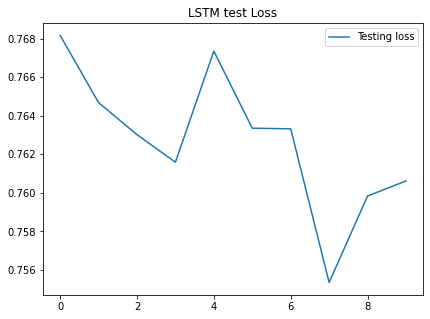

In [97]:
# curve for GRU test loss
fig = plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(test_loss_list, label='Testing loss')
plt.title("LSTM test Loss")
plt.legend()


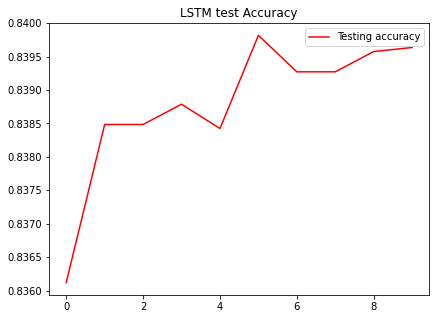

In [98]:
# curve for GRU test accuracy
fig = plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(test_accuracy, label='Testing accuracy', color = 'red')
plt.title("LSTM test Accuracy")
plt.legend()